# Final Project
Sarah Adilijiang (group member: Yanfei Zhou)

# Table of Content
`Please run the following code chunck to show the table of content.`
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
import lightgbm as lgb

pd.set_option('use_inf_as_na', True)
from collections import Counter
import pickle
from pandas.tseries.offsets import BDay

## Part 1: Choose the Top 10 Optimal Featues with the Highest Frequencies

In this part, we are given 9 optimal feature files. Each of these files contain a list of lists of optimal features for three classifiers: Random Forest Classifier, AdaBoosting Classifier, Gradient Boosting Classifier. We will compute the frequency for each feature which occurs as an optimal feature in the totality of these files. And then pick a set of 10 features with the highest frequencies as our optimal features for all the following back tests in this file.

#### 1. Combine all the features of the 9 optimal feature files into a single list

In [5]:
# optimal features for AdaBoosting Classifier
with open('../data/ada_opt_feat_4.pkl','rb') as f:
    ada_opt_feat_4 = pickle.load(f)
with open('../data/ada_opt_feat_5.pkl','rb') as f:
    ada_opt_feat_5 = pickle.load(f)
with open('../data/ada_opt_feat_6.pkl','rb') as f:
    ada_opt_feat_6 = pickle.load(f)

# optimal features for Gradient Boosting Classifier
with open('../data/gb_opt_feat_1.pkl','rb') as f:
    gb_opt_feat_1 = pickle.load(f)
with open('../data/gb_opt_feat_2.pkl','rb') as f:
    gb_opt_feat_2 = pickle.load(f)
with open('../data/gb_opt_feat_3.pkl','rb') as f:
    gb_opt_feat_3 = pickle.load(f)

# optimal features for Random Forest Classifier
with open('../data/opt_feat_4.pkl','rb') as f:
    opt_feat_4 = pickle.load(f)
with open('../data/opt_feat_5.pkl','rb') as f:
    opt_feat_5 = pickle.load(f)
with open('../data/opt_feat_6.pkl','rb') as f:
    opt_feat_6 = pickle.load(f)

In [6]:
opt_feats = [ada_opt_feat_4, ada_opt_feat_5, ada_opt_feat_6,
             gb_opt_feat_1,  gb_opt_feat_2,  gb_opt_feat_3,
             opt_feat_4,     opt_feat_5,     opt_feat_6]

# for opt in opt_feats:
#     print(len(opt))  # all has a lenghth of 62

all_feats = []
for opt in opt_feats:
    for i in range(len(opt)):
        all_feats += list(opt[i])
len(all_feats)  # all optimal features

8989

#### 2. Compute the frequency for each feature which occurs as an optimal feature in the totality of these files.

In [7]:
feat_count = Counter(all_feats)
feat_count

Counter({'capxy': 57,
         'rect_turnq': 81,
         'at4': 24,
         'actq': 30,
         'cshiq': 37,
         'cash_debtq': 46,
         'oiadpq': 42,
         'lt_ppentq': 102,
         'revty': 57,
         'oeps12': 47,
         'sale_equityq': 62,
         'txpdy': 79,
         'oepsxy': 82,
         'lagseq4': 13,
         'capital_ratioq': 23,
         'pay_turnq': 68,
         'cf_yield': 148,
         'pstkq': 6,
         'dvpspq': 81,
         'epsfxq': 55,
         'pcfq': 45,
         'bmq': 78,
         'sale_invcapq': 57,
         'int_totdebtq': 74,
         'seqq': 13,
         'ceq4': 20,
         'nopiq': 83,
         'pretret_noaq': 66,
         'lt_debtq': 43,
         'lagppent_alt4': 17,
         'cshprq': 28,
         'lctq': 21,
         'xsgay': 90,
         'fcf_ocfq': 94,
         'xsgaq': 50,
         'invtq': 29,
         'cogsq': 33,
         'int_debtq': 41,
         'dlcchy': 21,
         'at_turnq': 39,
         'debt_ebitdaq': 63,
         'd

In [8]:
len(feat_count)  # all unique features

284

#### 3. Pick a set of 10 features with the highest frequencies
- This will be used as our optimal_features for all the period (so we do not change features each quarter).

In [9]:
top10_feats = dict(sorted(feat_count.items(), key= lambda item: item[1], reverse=True)[0:10])
top10_feats

{'evmq': 174,
 'fcf_yield': 168,
 'cf_yield': 148,
 'oancfy_q': 121,
 'fcf_csfhdq': 114,
 'capeiq': 109,
 'lt_ppentq': 102,
 'chechy': 96,
 'fcf_ocfq': 94,
 'xsgay': 90}

In [10]:
optimal_features = list(top10_feats.keys())
optimal_features

['evmq',
 'fcf_yield',
 'cf_yield',
 'oancfy_q',
 'fcf_csfhdq',
 'capeiq',
 'lt_ppentq',
 'chechy',
 'fcf_ocfq',
 'xsgay']

## Part 2: Find a Good Set of Hyperparameters for Three Classifiers

Run several back tests with different sets of hyperparameters, using the 10 optimal features with highest frequencies that are picked in Part 1 through the whole period (so we do not change features each quarter) for each of the three classifiers below. Find the hyperparameters for each classifier from these experiments that give the best Sharpe Ratio: 
- Random Forest Classifier
- AdaBoosting Classifier
- Gradient Boosting Classifier

#### 1. Import data and only include companies with market cap $> 1B$ 

In [16]:
raw_data = pd.read_pickle('../data/dataset.pkl')
data = raw_data[raw_data['market_cap'] > 1000.0]
data.fillna(0.0, inplace=True) 

c:\users\gulishana\appdata\local\programs\python\python37\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [17]:
data.shape

(111468, 731)

In [18]:
data.head()

actq       apq        atq       ceqq      cheq  \
date       ticker                                                       
2000-02-09 CSCO    7722.000   482.000  21391.000  16523.000  3968.000   
           ROP      172.725    19.662    474.649    239.432     3.198   
2000-02-10 CMOS     240.767    27.044    376.536    209.411    68.625   
2000-02-11 DELL    7681.000  3538.000  11471.000   5308.000  4132.000   
2000-02-15 VAL      507.082   139.497   1094.080    402.382    27.605   

                      cogsq     csh12q    cshfdq     cshiq  cshopq  ...  \
date       ticker                                                   ...   
2000-02-09 CSCO    1422.000  3374.1250  3648.000  3445.000     0.0  ...   
           ROP       47.634    30.2688    31.217     0.000     0.0  ...   
2000-02-10 CMOS      43.023    21.4360    23.753     0.000     0.0  ...   
2000-02-11 DELL    5452.000  2536.0000  2731.000  2575.000     0.0  ...   
2000-02-15 VAL      221.366    43.1858    43.687    53.321     0.0  ...   

                   sector_code_815.0  sector_code_817.0  sector_code_822.0  \
date       ticker                                                            
2000-02-09 CSCO                    0                  0                  0   
           ROP                     0                  0                  0   
2000-02-10 CMOS                    0                  0                  0   
2000-02-11 DELL                    0                  0                  0   
2000-02-15 VAL                     0                  0                  0   

                   sector_code_823.0  sector_code_825.0  sector_code_830.0  \
date       ticker                                                            
2000-02-09 CSCO                    0                  0                  0   
           ROP                     0                  0                  0   
2000-02-10 CMOS                    0                  0                  0   
2000-02-11 DELL                    0                  0                  0   
2000-02-15 VAL                     0                  0                  0   

                   sector_code_835.0  sector_code_840.0  sector_code_845.0  \
date       ticker                                                            
2000-02-09 CSCO                    0                  0                  0   
           ROP                     0                  0                  0   
2000-02-10 CMOS                    0                  0                  0   
2000-02-11 DELL                    0                  0                  0   
2000-02-15 VAL                     0                  0                  0   

                   sector_code_850.0  
date       ticker                     
2000-02-09 CSCO                    0  
           ROP                     0  
2000-02-10 CMOS                    0  
2000-02-11 DELL                    0  
2000-02-15 VAL                     0  

[5 rows x 731 columns]

#### 2. Define label: $y \in \{1,0,-1\}$
Insert a column in the data set with entries: 
- (1) 1 if the Stock return is more then 1% higher than the SPY return; 
- (2) 0 if it is between -1% and 1%; 
- (3) -1 if the Stock underperforms the SPY by more than -1%.

In [19]:
def f(x):
    if x > 0.01:
        return 1
    elif x < -0.01:
        return -1
    else:
        return 0

In [22]:
data['rel_performance'] = data['pred_rel_return'].apply(f)
data.reset_index(inplace=True,)
data.set_index('date', inplace=True)

c:\users\gulishana\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [23]:
data.shape

(111468, 733)

In [24]:
data.head()

,ticker,actq,apq,atq,ceqq,cheq,cogsq,csh12q,cshfdq,cshiq,...,sector_code_817.0,sector_code_822.0,sector_code_823.0,sector_code_825.0,sector_code_830.0,sector_code_835.0,sector_code_840.0,sector_code_845.0,sector_code_850.0,rel_performance
date,,,,,,,,,,,,,,,,,,,,,
2000-02-09,CSCO,7722.000,482.000,21391.000,16523.000,3968.000,1422.000,3374.1250,3648.000,3445.000,...,0,0,0,0,0,0,0,0,0,-1
2000-02-09,ROP,172.725,19.662,474.649,239.432,3.198,47.634,30.2688,31.217,0.000,...,0,0,0,0,0,0,0,0,0,1
2000-02-10,CMOS,240.767,27.044,376.536,209.411,68.625,43.023,21.4360,23.753,0.000,...,0,0,0,0,0,0,0,0,0,1
2000-02-11,DELL,7681.000,3538.000,11471.000,5308.000,4132.000,5452.000,2536.0000,2731.000,2575.000,...,0,0,0,0,0,0,0,0,0,1
2000-02-15,VAL,507.082,139.497,1094.080,402.382,27.605,221.366,43.1858,43.687,53.321,...,0,0,0,0,0,0,0,0,0,1


#### 3. Construct training data and test data

Here we also keep the columns of `ticker` and `date` in the data as well, which will be needed later to compute the list of all trades predicted by the model. Since the top 10 optimal features have already been decided, adding two columns would not affect the fitted model.

In [12]:
start_dates = [pd.to_datetime('2000-01-01') + pd.DateOffset(months = 3 * i) for i in range(62)]
end_dates = [d + pd.DateOffset(months = 36) for d in start_dates]

training_frames = [data.loc[d:d+pd.DateOffset(months = 36)] for d in start_dates]
test_frames = [data.loc[d+pd.DateOffset(months=3) : d+pd.DateOffset(months=6)] for d in end_dates]

training_data = [d.reset_index().drop
                                 (['next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in training_frames]

test_data = [d.reset_index().drop(['next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in test_frames]

training_labels = [d['rel_performance'].values for d in training_frames]
validation_labels = [d['rel_performance'].values for d in test_frames]

In [13]:
# show the first 5 & the last 5 of learning periods
for i in list(range(5)):
    print(("0"+str(i))[-2:], "training: ", str(training_data[i]["date"].min())[:10], str(training_data[i]["date"].max())[:10], "     ",
             "test: ",str(test_data[i]["date"].min())[:10], str(test_data[i]["date"].max())[:10] )
print("......")
for i in list(range(len(training_data)-5,len(training_data))):
    print(("0"+str(i))[-2:], "training: ", str(training_data[i]["date"].min())[:10], str(training_data[i]["date"].max())[:10], "     ",
             "test: ",str(test_data[i]["date"].min())[:10], str(test_data[i]["date"].max())[:10] )

00 training:  2000-02-09 2002-12-23       test:  2003-04-01 2003-07-01
01 training:  2000-04-03 2003-04-01       test:  2003-07-01 2003-10-01
02 training:  2000-07-03 2003-07-01       test:  2003-10-01 2003-12-30
03 training:  2000-10-03 2003-10-01       test:  2004-01-06 2004-04-01
04 training:  2001-01-04 2003-12-30       test:  2004-04-01 2004-07-01
......
57 training:  2014-04-01 2017-03-31       test:  2017-07-03 2017-09-29
58 training:  2014-07-02 2017-06-30       test:  2017-10-02 2017-12-27
59 training:  2014-10-02 2017-09-29       test:  2018-01-04 2018-03-29
60 training:  2015-01-07 2017-12-27       test:  2018-04-02 2018-06-29
61 training:  2015-04-01 2018-03-29       test:  2018-07-02 2018-10-01


### Random Forest Classifier

#### 1st Set of Hyperparameters  

- `max_depth = 5`
- `min_samples_leaf = 1500`
- `max_features = 'sqrt'`    
- `n_estimators = 30`

In [14]:
rf_clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1500, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, max_depth=5, n_jobs=1,
            oob_score=False, random_state=123, verbose=0, warm_start=False)

In [15]:
P_L = []
x = [0,1]
ret = []

for i in range(1,len(training_data)-1):
    
        rf_clf.fit(training_data[i][optimal_features], training_labels[i])
        pred_i = rf_clf.predict(test_data[i][optimal_features])
        
        profit_i = (pred_i * test_frames[i]['next_period_return']).sum()
        P_L.append(profit_i)
        positions = np.sum(np.abs(pred_i))
        
        ret.append((1.0/positions) * profit_i)
        x.append(x[i] + (x[i]/positions) * profit_i)

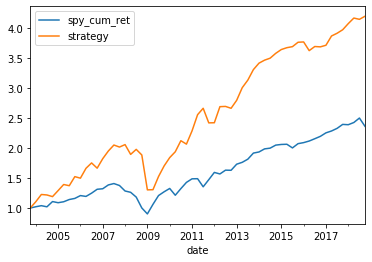

In [16]:
SPY = pd.read_pickle('../data/SPY_cum_ret.pkl')
SPY = SPY.loc['2003-10-01':]
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x[1:]
SPY.plot();

In [17]:
SPY = SPY.resample('A').bfill()
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Sharpe Ratio: ',strategy_sr)

Sharpe Ratio:  0.997927726377211


#### 2nd Set of Hyperparameters

- `max_depth = 6`
- `min_samples_leaf = 1600`
- `max_features = 'sqrt'`    
- `n_estimators = 20`

In [18]:
rf_clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1600, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, max_depth=6, n_jobs=1,
            oob_score=False, random_state=123, verbose=0, warm_start=False)

In [19]:
P_L = []
x = [0,1]
ret = []

for i in range(1,len(training_data)-1):
    
        rf_clf.fit(training_data[i][optimal_features],training_labels[i])
        pred_i = rf_clf.predict(test_data[i][optimal_features])
        
        profit_i = (pred_i * test_frames[i]['next_period_return']).sum()
        P_L.append(profit_i)
        positions = np.sum(np.abs(pred_i))
        
        ret.append((1.0/positions) * profit_i)
        x.append(x[i] + (x[i]/positions) * profit_i)

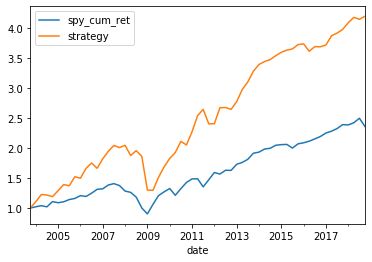

In [20]:
SPY = pd.read_pickle('../data/SPY_cum_ret.pkl')
SPY = SPY.loc['2003-10-01':]
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x[1:]
SPY.plot();

In [21]:
SPY = SPY.resample('A').bfill()
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Sharpe Ratio: ', strategy_sr)

Sharpe Ratio:  1.0215651570056483


#### 3rd Set of Hyperparameters 

- `max_depth = 4`
- `min_samples_leaf = 1200`
- `max_features = 'sqrt'`    
- `n_estimators = 40`

In [22]:
rf_clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1200, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, max_depth=4, n_jobs=1,
            oob_score=False, random_state=123, verbose=0, warm_start=False)

In [23]:
P_L = []
x = [0,1]
ret = []

for i in range(1,len(training_data)-1):
    
        rf_clf.fit(training_data[i][optimal_features],training_labels[i])
        pred_i = rf_clf.predict(test_data[i][optimal_features])
        
        profit_i = (pred_i * test_frames[i]['next_period_return']).sum()
        P_L.append(profit_i)
        positions = np.sum(np.abs(pred_i))
        
        ret.append((1.0/positions) * profit_i)
        x.append(x[i] + (x[i]/positions) * profit_i)

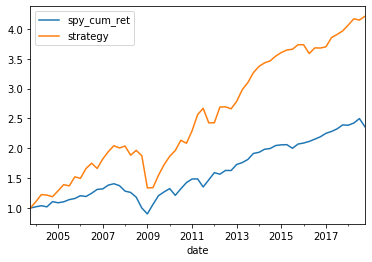

In [24]:
SPY = pd.read_pickle('../data/SPY_cum_ret.pkl')
SPY = SPY.loc['2003-10-01':]
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x[1:]
SPY.plot();

In [25]:
SPY = SPY.resample('A').bfill()
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Sharpe Ratio: ',strategy_sr)

Sharpe Ratio:  1.0711487109453355


#### Result: the best set of hyperparameters for Random Forest Classifier

- `max_depth = 4`
- `min_samples_leaf = 1200`
- `max_features = 'sqrt'`    
- `n_estimators = 40`

This set of hyperparameters provides the largest Sharpe Ratio: 1.0711487109453355

### AdaBoosting Classifier

#### 1st Set of Hyperparameters
  
- `max_depth = 4`
- `n_estimators = 50`
- `learning_rate = 0.4`

In [26]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=4),n_estimators=50,learning_rate=0.4,algorithm="SAMME.R")

In [27]:
P_L = []
x = [0,1]
ret = []

for i in range(1,len(training_data)-1):
    
    ada_clf.fit(training_data[i][optimal_features],training_labels[i])
    pred_i = ada_clf.predict(test_data[i][optimal_features])
        
    profit_i = (pred_i * test_frames[i]['next_period_return']).sum()
    P_L.append(profit_i)
    positions = np.sum(np.abs(pred_i))
        
    ret.append((1.0/positions) * profit_i)
    x.append(x[i] + (x[i]/positions) * profit_i)

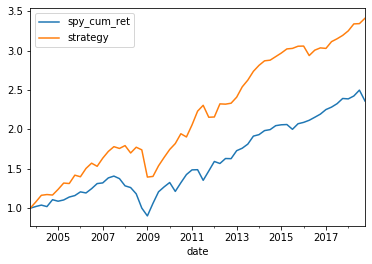

In [28]:
SPY = pd.read_pickle('../data/SPY_cum_ret.pkl')
SPY = SPY.loc['2003-10-01':]
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x[1:]
SPY.plot();

In [29]:
SPY = SPY.resample('A').bfill()
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Sharpe Ratio: ',strategy_sr)

Sharpe Ratio:  1.2578868969340766


#### 2nd Set of Hyperparameters
  
- `max_depth = 5`
- `n_estimators= 40`
- `learning_rate = 0.5`

In [30]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5),n_estimators=40,learning_rate=0.5,algorithm="SAMME.R")

In [31]:
P_L = []
x = [0,1]
ret = []

for i in range(1,len(training_data)-1):
    
    ada_clf.fit(training_data[i][optimal_features],training_labels[i])
    pred_i = ada_clf.predict(test_data[i][optimal_features])
        
    profit_i = (pred_i * test_frames[i]['next_period_return']).sum()
    P_L.append(profit_i)
    positions = np.sum(np.abs(pred_i))
        
    ret.append((1.0/positions) * profit_i)
    x.append(x[i] + (x[i]/positions) * profit_i)

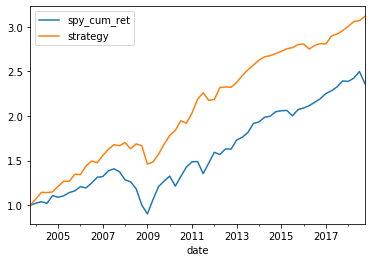

In [32]:
SPY = pd.read_pickle('../data/SPY_cum_ret.pkl')
SPY = SPY.loc['2003-10-01':]
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x[1:]
SPY.plot();

In [33]:
SPY = SPY.resample('A').bfill()
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Sharpe Ratio: ',strategy_sr)

Sharpe Ratio:  1.7148962691675238


#### 3rd Set of Hyperparameters
  
- `max_depth = 6`
- `n_estimators= 30`
- `learning_rate = 0.6`

In [34]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=6),n_estimators=30,learning_rate=0.6,algorithm="SAMME.R")

In [35]:
P_L = []
x = [0,1]
ret = []

for i in range(1,len(training_data)-1):
    
    ada_clf.fit(training_data[i][optimal_features],training_labels[i])
    pred_i = ada_clf.predict(test_data[i][optimal_features])
        
    profit_i = (pred_i * test_frames[i]['next_period_return']).sum()
    P_L.append(profit_i)
    positions = np.sum(np.abs(pred_i))
        
    ret.append((1.0/positions) * profit_i)
    x.append(x[i] + (x[i]/positions) * profit_i)

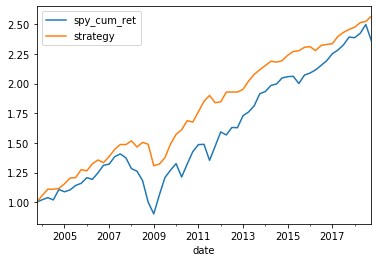

In [36]:
SPY = pd.read_pickle('../data/SPY_cum_ret.pkl')
SPY = SPY.loc['2003-10-01':]
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x[1:]
SPY.plot();

In [37]:
SPY = SPY.resample('A').bfill()
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Sharpe Ratio: ',strategy_sr)

Sharpe Ratio:  1.6915208938762503


#### Result: the best set of hyperparameters for AdaBoosting Classifier

- `max_depth = 5`
- `n_estimators= 40`
- `learning_rate = 0.5`

This set of hyperparameters provides the largest Sharpe Ratio: 1.7148962691675238

### Gradient Boosting Classifier

#### 1st Set of Hyperparameters
  
- `max_depth = 4`
- `min_data_in_leaf = 1500`
- `num_leaves = 10`
- `n_estimators= 400`
- `reg_lambda = 0.5`
- `learning_rate = 0.1`

In [38]:
gb_clf = lgb.LGBMClassifier(max_depth=4,n_estimators=400,objective='multi_class',min_data_in_leaf=1500,
                            reg_lambda=0.5,num_leaves=10,learning_rate=0.1)

In [39]:
P_L = []
x = [0,1]
ret = []

for i in range(1,len(training_data)-1):
    
        gb_clf.fit(training_data[i][optimal_features],training_labels[i])
        pred_i = gb_clf.predict(test_data[i][optimal_features])
        
        profit_i = (pred_i * test_frames[i]['next_period_return']).sum()
        P_L.append(profit_i)
        positions = np.sum(np.abs(pred_i))
        
        ret.append((1.0/positions) * profit_i)
        x.append(x[i] + (x[i]/positions) * profit_i)

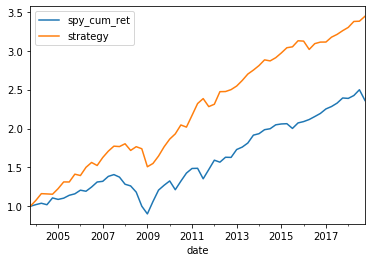

In [40]:
SPY = pd.read_pickle('../data/SPY_cum_ret.pkl')
SPY = SPY.loc['2003-10-01':]
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x[1:]
SPY.plot();

In [41]:
SPY = SPY.resample('A').bfill()
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Sharpe Ratio: ',strategy_sr)

Sharpe Ratio:  1.6362702641893363


#### 2nd Set of Hyperparameters
  
- `max_depth = 5`
- `min_data_in_leaf = 1800`
- `num_leaves = 15`
- `n_estimators= 400`
- `reg_lambda = 0.5`
- `learning_rate = 0.2`

In [42]:
gb_clf = lgb.LGBMClassifier(max_depth=5,n_estimators=400,objective='multi_class',min_data_in_leaf=1800,
                            reg_lambda=0.5,num_leaves=15,learning_rate=0.2)

In [43]:
P_L = []
x = [0,1]
ret = []

for i in range(1,len(training_data)-1):
    
        gb_clf.fit(training_data[i][optimal_features],training_labels[i])
        pred_i = gb_clf.predict(test_data[i][optimal_features])
        
        profit_i = (pred_i * test_frames[i]['next_period_return']).sum()
        P_L.append(profit_i)
        positions = np.sum(np.abs(pred_i))
        
        ret.append((1.0/positions) * profit_i)
        x.append(x[i] + (x[i]/positions) * profit_i)

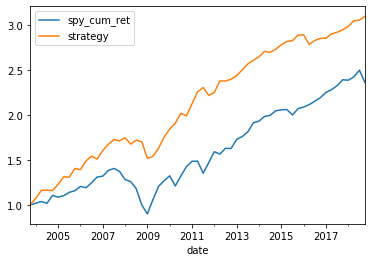

In [44]:
SPY = pd.read_pickle('../data/SPY_cum_ret.pkl')
SPY = SPY.loc['2003-10-01':]
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x[1:]
SPY.plot();

In [45]:
SPY = SPY.resample('A').bfill()
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Sharpe Ratio: ',strategy_sr)

Sharpe Ratio:  1.6252620401673017


#### 3rd Set of Hyperparameters
  
- `max_depth = 6`
- `min_data_in_leaf = 2100`
- `num_leaves = 20`
- `n_estimators= 400`
- `reg_lambda = 0.5`
- `learning_rate = 0.3`

In [46]:
gb_clf = lgb.LGBMClassifier(max_depth=6,n_estimators=400,objective='multi_class',min_data_in_leaf=2100,
                            reg_lambda=0.5,num_leaves=20,learning_rate=0.3)

In [47]:
P_L = []
x = [0,1]
ret = []

for i in range(1,len(training_data)-1):
    
        gb_clf.fit(training_data[i][optimal_features],training_labels[i])
        pred_i = gb_clf.predict(test_data[i][optimal_features])
        
        profit_i = (pred_i * test_frames[i]['next_period_return']).sum()
        P_L.append(profit_i)
        positions = np.sum(np.abs(pred_i))
        
        ret.append((1.0/positions) * profit_i)
        x.append(x[i] + (x[i]/positions) * profit_i)

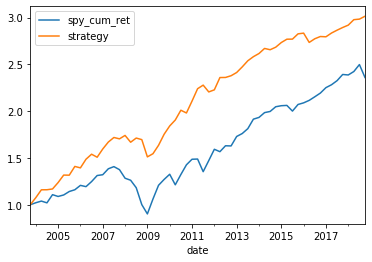

In [48]:
SPY = pd.read_pickle('../data/SPY_cum_ret.pkl')
SPY = SPY.loc['2003-10-01':]
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x[1:]
SPY.plot();

In [49]:
SPY = SPY.resample('A').bfill()
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Sharpe Ratio: ',strategy_sr)

Sharpe Ratio:  1.6190976842648315


#### Result: the best set of hyperparameters for Gradient Boosting Classifier

- `max_depth = 4`
- `min_data_in_leaf = 1500`
- `num_leaves = 10`
- `n_estimators= 400`
- `reg_lambda = 0.5`
- `learning_rate = 0.1`

This set of hyperparameters provides the largest Sharpe Ratio: 1.6362702641893363

## Part 3: Fit a Voting Classifier

Use the best set of hyperparameters you found for each of three basis classifier above and the 10 optimal features to make a Voting Classifier. Then run a back test for this Voting Classifier, and computes Sharpe Ratio, Information Ration, alpha $\alpha$ and Max Drawdown.

### 1. Build and Fit a Voting Classifier

- Set up three basis classifiers: Random Forest, AdaBoosting, Gradient Boosting, using the corresponding best set of hyperparamters chosen above for each basis classifier
- Based on these three basis classifiers, use the above 10 optimal features to make a Voting Classifier 

In [50]:
rf_clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1200, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, max_depth=4, n_jobs=1,
            oob_score=False, random_state=123, verbose=0, warm_start=False)

In [51]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5),n_estimators=40,learning_rate=0.5,algorithm="SAMME.R")

In [52]:
gb_clf = lgb.LGBMClassifier(max_depth=4,n_estimators=400,objective='multi_class',min_data_in_leaf=1500,
                            reg_lambda=0.5,num_leaves=10,learning_rate=0.1)

In [53]:
v_clf = VotingClassifier(estimators=[('rf', rf_clf), ('ada', ada_clf), ('gb', gb_clf)], voting='hard')

In [54]:
P_L = []
x = [0,1]
ret = []
preds = []

for i in range(1,len(training_data)-1):
    
        v_clf.fit(training_data[i][optimal_features],training_labels[i])
        pred_i = v_clf.predict(test_data[i][optimal_features])
        
        preds.append(pred_i)   # prediction from the Voting Classifier for each stock
        
        profit_i = (pred_i * test_frames[i]['next_period_return']).sum()
        P_L.append(profit_i)
        positions = np.sum(np.abs(pred_i))
        
        ret.append((1.0/positions) * profit_i)
        x.append(x[i] + (x[i]/positions) * profit_i)

Here we also stored the predictions from the Voting Classifier for each stock in the testing period to compute the list of all traders predicted by the model in the next Part.

### 2. Model Performance Results: Total P/L, Sharpe Ratio, Information Ratio, Alpha $\alpha$, Max Drawdown

Run a back test for this Voting Classifier, and computes the Sharpe Ratio, Information Ration, alpha $\alpha$ and Max Drawdown.

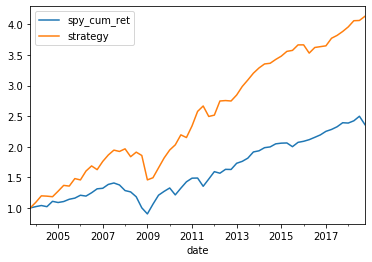

In [55]:
SPY = pd.read_pickle('../data/SPY_cum_ret.pkl')
SPY = SPY.loc['2003-10-01':]
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x[1:]
SPY.plot();

In [56]:
def max_drawdown(returns):
        local_max = [n for n in range(len(returns)-1) if ((n==0) and (returns[0] > returns[1])) or 
           ((n > 0) and  (returns[n-1]<returns[n]) and (returns[n+1]<returns[n]))] 

        local_min = [n for n in range(1,len(returns)) if ((n == len(returns)-1) and (returns[-1] < returns[-2])) or
                (returns[n-1]>returns[n]) and (returns[n+1]>returns[n])]

        def next_local_min(n):
            if [m for m in local_min if m > n]:
                return [m for m in local_min if m > n][0]
            else: return None

        drawdowns = [(n,next_local_min(n)) for n in local_max]
        drawdown_values = [returns[n] - returns[m] for (n,m) in drawdowns if m != None]
        if drawdown_values:
            return  np.max(drawdown_values)
        else: return 0.0

In [58]:
def max_dd(returns):
    i = np.argmax(np.maximum.accumulate(returns) - returns)
    j = np.argmax(returns[:i])
    plt.plot(returns);
    plt.plot([i, j], [returns[i], returns[j]], 'o', color='Red', markersize=10)
    return np.abs(returns[j] - returns[i])

Total P/L:  4.132873740636822
Sharpe Ratio:  1.3926980297737317
Information Ratio: 1.2949462404339067
Alpha: 0.1752940717803241
Max Drawdown: 0.10663920665432225


C:\Users\Gulishana\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


0.10663920665432225

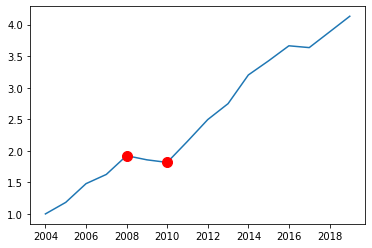

In [59]:
# Total P/L
print("Total P/L: ", x[-1])  # how much dollars will 1 dollar become

# Sharpe Ratio
SPY = SPY.resample('A').bfill()
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Sharpe Ratio: ',strategy_sr)

# Information Ratio
strategy_ret = (SPY['strategy'] - 1).diff().values[1:]
spy_ret = (SPY['spy_cum_ret'] - 1).diff().values[1:]
beta = (np.cov(spy_ret,strategy_ret)/np.var(spy_ret))[1,0]
residual_ret = strategy_ret - beta * spy_ret
IR = np.mean(residual_ret)/np.std(residual_ret)
print('Information Ratio:',IR)

# alpha
alpha = np.mean(residual_ret)
print('Alpha:',alpha)

# Max Drawdown
print("Max Drawdown:", max_drawdown(SPY['strategy']) )
max_dd(SPY['strategy'])

**Model Performance Results of the Voting Classifier**:

- `Total P/L = 4.132873740636822`
- `Sharpe Ratio = 1.3926980297737317`
- `Information Ratio = 1.2949462404339067`
- `Alpha = 0.1752940717803241`
- `Max Drawdown = 0.10663920665432225`

## Part 4: List of All Trades

### 1. Compute the list of all trades in one selected quarter predicted by the model

- Pick a quarter from the period 2000-2018.
- For each trading day in the quarter period (i.e. the day after an earnings release) compute the prediction from the Voting Classifier for each stock (with market cap > 1B) in the data set which can be traded on this date.
- Compute the list of all trades predicted by the model.

In [60]:
i = 40
print("Quarter (in test data):  ",str(test_data[i]["date"].min())[:10]," to ",str(test_data[i]["date"].max())[:10] )

Quarter (in test data):   2013-04-01  to  2013-07-01


In [61]:
# len(test_data), len(preds)

In [62]:
# pd.DataFrame(test_data[i][['ticker','date']]).shape

In [63]:
quarter = pd.DataFrame(test_data[i][['ticker','date']])
quarter['prediction'] = preds[i-1]

quarter['earnings_date'] = quarter['date'].map(lambda x:x-BDay(n=1))  # BDay():  possibly n business days, default n=1
quarter.rename(columns={'date':'trading_date'}, inplace=True)
quarter.reset_index(inplace=True, drop=True)
quarter.set_index('trading_date', inplace=True)
quarter

,ticker,prediction,earnings_date
trading_date,,,
2013-04-01,KYAK,1,2013-03-29
2013-04-02,ACH,-1,2013-04-01
2013-04-03,GPN,1,2013-04-02
2013-04-03,MKC,1,2013-04-02
2013-04-04,AYI,1,2013-04-03
...,...,...,...
2013-06-28,MKC,1,2013-06-27
2013-06-28,NKE,1,2013-06-27
2013-06-28,WOR,1,2013-06-27


Using the predictions for each stock in each testing period, we computed the list of all trades. Here the printed result shows following informations:
- `trading_date` (i.e, the day after an earnings release) 
- `ticker` (i.e. stock company name)
- `prediction` (i.e. trading action: +1 represents buying, -1 represents selling, 0 represents doing nothing)
- `earnings_date` (i.e. earnings release date)

### 2. Compute the list of all trades of the whole period predicted by the model

Use the same procedure as above.But instead of only computing for one quarter, now we compute list of all trades for the whole period.

In [64]:
df = pd.DataFrame(test_data[1][['ticker','date']])
df['prediction'] = preds[0]

for i in range(2,len(test_data)-1):
    df_i = pd.DataFrame(test_data[i][['ticker','date']])
    df_i['prediction'] = preds[i-1]
    df = pd.concat([df, df_i], axis=0)

df['earnings_date'] = df['date'].map(lambda x:x-BDay())
df.rename(columns={'date':'trading_date'}, inplace=True)
df.reset_index(inplace=True, drop=True)
df.set_index('trading_date', inplace=True)
df

,ticker,prediction,earnings_date
trading_date,,,
2003-07-01,IBN,1,2003-06-30
2003-07-02,EMMS,1,2003-07-01
2003-07-02,STZ,1,2003-07-01
2003-07-08,OOM,1,2003-07-07
2003-07-09,AMB,1,2003-07-08
...,...,...,...
2018-06-29,MKC,1,2018-06-28
2018-06-29,NKE,1,2018-06-28
2018-06-29,SHLM,1,2018-06-28


## Part 5: Trading Strategy #1

**Strategy Procedure**:

- We start with 1 dollar.

- For each quarter, `allocate our capital equally among stocks` we consider in the quarter, the stocks that are available will vary from quarter to quarter.

- We go 
  - **long** each `Stock` with prediction **+1**
  - **short** each `Stock` with prediction **-1**
  - **do nothing** if the prediction is **0**

- We hold until the day after the next earnings release. 

Since the **predictions** predicted by the Voting Classifier above for each stock in the testing period represent the **trading actions**: 
- **+1** represents buying
- **-1** represents selling
- **0** represents doing nothing

Therefore, the Strategy used in the Voting Classifier above is just the Strategy #1 we want here. And its results are shown below again as the results of the Strategy #1.

### Strategy 1# Performance Results: Total P/L, Sharpe Ratio, Information Ratio, Alpha $\alpha$, Max Drawdown

- `Total P/L = 4.132873740636822`
- `Sharpe Ratio = 1.3926980297737317`
- `Information Ratio = 1.2949462404339067`
- `Alpha = 0.1752940717803241`
- `Max Drawdown = 0.10663920665432225`

## Part 6: Trading Strategy #2

**Strategy Procedure**:

- We start with 1 dollar.

- For each quarter, `allocate our capital equally among trades` we consider in the quarter, the trades that are available will vary from quarter to quarter.

- We go 
  - **buy** the `Stock` and **short** the `SPY` with prediction **+1**
  - **short** the `Stock` and **buy** the `SPY` with prediction **-1**
  - **do nothing** if the prediction is **0**
  - Note: here we treat each one of three combined trading actions of `Stock` and `SPY` above as one trade in that period.

- We hold until the day after the next earnings release. 

We can see that the only difference between Strategy #2 and the Strategy #1 is the trading actions in each period. **Strategy #1** trades only `Stock`, however, **Strategy #2** trades `Stock` and `SPY` at the same time. Therefore, within each trade, we need to decide how to allocate our capital between the `Stock` and `SPY`.

Here I tried different combinations of capital allocation ratio for `Stock` and `SPY`: 
- **`0.5:0.5, 0.6:0.4, 0.7:0.3, 0.8:0.2, 0.9:0.1, 1.0:0`**

For example, if we use the capital allocation ratio of **0.8:0.2 (Stock/SPY)**. Suppose we have capital = $m$ at the begining of a quarter and we consider $n$ companies to trade in that quarter. Since for each quarter, we allocate our capital equally among trades we consider in this quarter, so we will allocate $m/n$ dollars to each company. Then, if the prediction of that company is **+1** in this period, then we will use $0.8 m/n$ dollars to **buy** the `Stock` and use $0.2 m/n$ dollars to **short** the `SPY`.

Note that when using 1.0 Stock/0.0 SPY, it is just the same as **Strategy #1**.

The Strategy Performance Results are shown as below.

### Strategy 2# Performance Results: Total P/L, Sharpe Ratio, Information Ratio, Alpha $\alpha$, Max Drawdown

In [68]:
df = pd.DataFrame(columns=["Stock","SPY","Total_P/L","Sharpe_Ratio","Information_Ratio","alpha","Max_Drawdown"])

for k in range(5,11):
    df.loc[k, ["Stock","SPY"]] = [k/10, 1-k/10]
    
    # Implement Strategy: different allocations on Stock and SPY
    P_L = []
    x = [0,1]
    ret = []
    for i in range(1,len(test_frames)-1):
        profit_i = (  k/10 * preds[i-1] * test_frames[i]['next_period_return'] \
                    - (1-k/10) * preds[i-1] * test_frames[i]['spy_next_period_return'] ).sum()
        P_L.append(profit_i)
        positions = np.sum(np.abs(preds[i-1]))
        ret.append((1.0/positions) * profit_i)
        x.append(x[i] + (x[i]/positions) * profit_i)
    
    # Total P/L
    df.loc[k,"Total_P/L"] = x[-1]

    # Sharpe Ratio
    SPY = pd.read_pickle('../data/SPY_cum_ret.pkl')
    SPY = SPY.loc['2003-10-01':]
    SPY = SPY.resample('Q').ffill()
    SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
    SPY['strategy'] = x[1:]
    SPY = SPY.resample('A').bfill()
    strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
    strategy_std = (SPY['strategy'] - 1).diff().std()
    df.loc[k,"Sharpe_Ratio"] = strategy_mean_ret/strategy_std

    # Information Ratio
    strategy_ret = (SPY['strategy'] - 1).diff().values[1:]
    spy_ret = (SPY['spy_cum_ret'] - 1).diff().values[1:]
    beta = (np.cov(spy_ret,strategy_ret)/np.var(spy_ret))[1,0]
    residual_ret = strategy_ret - beta * spy_ret
    df.loc[k,"Information_Ratio"] = np.mean(residual_ret)/np.std(residual_ret)

    # alpha
    df.loc[k,"alpha"] = round(np.mean(residual_ret),5)

    # Max Drawdown
    df.loc[k,"Max_Drawdown"] = round(max_drawdown(SPY['strategy']),5)

df.set_index(["Stock","SPY"], inplace=True)

In [69]:
df

,,Total_P/L,Sharpe_Ratio,Information_Ratio,alpha,Max_Drawdown
Stock,SPY,,,,,
0.5,0.5,1.32522,1.20684,1.30461,0.02257,0.01028
0.6,0.4,1.68359,1.63963,1.6063,0.04243,0.00839
0.7,0.3,2.12631,1.61525,1.55056,0.0667,0.0115
0.8,0.2,2.66959,1.53592,1.45684,0.09626,0.01836
0.9,0.1,3.33169,1.46031,1.37085,0.13209,0.05055
1.0,0.0,4.13287,1.3927,1.29495,0.17529,0.10664


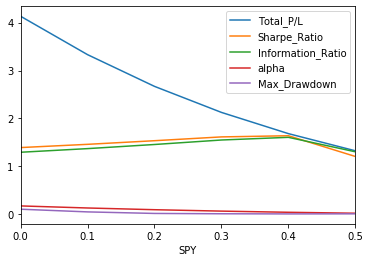

In [70]:
df.reset_index(inplace=True)
df.drop("Stock", axis=1, inplace=True)
df.set_index("SPY", inplace=True)
df.plot();

**Results**:

We can see that, as the percentile of the capital that the trading for `SPY` gets in each trade increases:

- Total P/L decreases
- Sharpe Ratio and Information Ratio both first increase then decrease, and they get their highest values at 0.4 (i.e. 0.6 Stock/0.4 SPY)
- Alpha and Max Darwdown both slightly decrease

### Comparing Strategy #1 & Strategy #2
Since when using **1.0 Stock/0.0 SPY** is just the same as **Strategy #1**, we can look at the above figure and conclude that:
- Strategy #2 will generally have lower total P/L than Strategy #1.
- Strategy #2 may have larger or lower Sharpe Ratio and Information Ratio than Strategy #1, which depends on the capital allocation ratio for Stock and SPY. When using about 0.6 Stock/0.4 SPY, the Sharpe Ratio and Information Ratio of Strategy #2 can be maximized for this model.
- Strategy #2 will generally have lower Alpha and Max Darwdown than Strategy #1, but the difference is very small.